In [1]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
plt.rcParams["font.family"] = "Arial"
# from skimage import measure
import pyvista as pv
pv.set_jupyter_backend('trame')
from tqdm import tqdm, trange
from scipy import interpolate, ndimage, fft
from scipy.io import savemat
from time import time

## Define function

In [2]:
def sample_k(k_mean,k_cov):
    return np.random.multivariate_normal(k_mean,k_cov)

#### Superpositioning the random wave ####
def rotation_matrix(axis, phi):
    """
    Return the rotation matrix associated with counterclockwise rotation about
    the given axis by theta radians.
    """
    axis = np.asarray(axis)
    axis = axis / np.sqrt(np.dot(axis, axis))
    a = np.cos(phi / 2.0)
    b, c, d = -axis * np.sin(phi / 2.0)
    aa, bb, cc, dd = a * a, b * b, c * c, d * d
    bc, ad, ac, ab, bd, cd = b * c, a * d, a * c, a * b, b * d, c * d
    return np.array([[aa + bb - cc - dd, 2 * (bc + ad), 2 * (bd - ac)],
                     [2 * (bc - ad), aa + cc - bb - dd, 2 * (cd + ab)],
                     [2 * (bd + ac), 2 * (cd - ab), aa + dd - bb - cc]])

def sample_wave_MO_complex(r_grid, k_mean, k_cov, n_wave = 100, kappa=1e8):
    rho = np.zeros_like(r_grid[0]).astype('complex64')
    r_grid = [r.astype(np.float32) for r in r_grid]
    for i in range(n_wave):
        k_sample = sample_k(k_mean,k_cov)

        # misorientation
        """
        https://en.wikipedia.org/wiki/Von_Mises%E2%80%93Fisher_distribution
        https://doi.org/10.1080/03610919408813161
        """
        sigma = 1e-6
        xi = np.random.rand()
        theta = np.random.rand()*2*np.pi
        W = 1+1/kappa*(np.log(xi*(1-(xi-1)/xi*np.exp(-2*kappa))))
        phi = np.arccos(W)
        axis = [np.cos(theta),np.sin(theta),0]
        R = rotation_matrix(axis,phi)
        k_sample_rot = R@k_sample

        k_dot_r = np.sum([r_grid[x]*k_sample_rot[x] for x in range(3)],axis=0)
        phi_r = np.random.rand()*2*np.pi # random phase
        rho_i = np.exp(1j*(k_dot_r + phi_r)) # cos(k_n.r + phi_n)
        rho += rho_i.astype('complex64')

    rho = np.sqrt(2/n_wave)*rho
    
    return rho

## Generate random wave

In [3]:
## Meshgrid
n_grid = 160
x = np.linspace(-1,1,n_grid+1)
y = np.linspace(-1,1,n_grid+1)
z = np.linspace(-1,1,n_grid+1)

r_grid = np.meshgrid(x,y,z) 

## Random wave
sigma_k = 0.2
kappa = 1
alpha = 0

#### Wave vector distribution ####
scale = 3
k_mean_z = np.array([0,0,scale])*2*np.pi # lamellar perpendicular to z axis 
# k_mean_x = np.array([0,0,0])*np.pi # lamellar perpendicular to z axis 
k_var  = (np.array([0,0,sigma_k*scale])*2*np.pi)**2
k_cov  = np.diagflat(k_var)

rho = sample_wave_MO_complex(r_grid,k_mean_z,k_cov,n_wave = 100, kappa=kappa)

n_grid_scale = 480
scale_zoom = n_grid_scale/rho.shape[0]

def scale_rho(rho, r_grid, scale):
    rho = ndimage.zoom(rho, scale, order=1)
    r_grid = np.array([ndimage.zoom(r, scale, order=1) for r in r_grid]) 
    return rho, r_grid

rho, r_grid = scale_rho(rho, r_grid, scale_zoom)

rho_real = rho.real
rho_imag = rho.imag
rho_phase = np.angle(rho)

## Identify vortex lines

In [4]:
## identify vortex line (cube, not working)
# example of a single cube
# '''
#     (4)--------(7)
#     /|         /|
#    / |        / |
#  (3)--------(5) |
#   | (2)------|-(6)
#   | /        | /
#   |/         |/
#  (0)--------(1)
# '''
# cube_coord = np.array([0,0,0])
# list_vertices = [[0,0,0], [1,0,0], [0,1,0], [0,0,1], 
#                  [0,1,1], [1,0,1], [1,0,1], [1,1,1]]
# list_faces = [[0,1,6,2],[3,4,7,5],[0,3,5,1],[2,6,7,4],[0,2,4,3],[1,5,7,6]]
# cube_vertices = np.array(list_vertices) + cube_coord


In [5]:
## identify vortex line (slice of plane)
def vortex_slice(phase_slice):
    '''
    Input
    phase_slice: 2D array of phase field (floats, -pi to pi).

    Output
    vortex_array: 2D array of vortex locations (binary)
    ----------------------------------------------------------------
     --- --- ---
    | 1 | 8 | 7 |
    --- --- --- 
    | 2 | p | 6 |
    --- --- ---
    | 3 | 4 | 5 |
    --- --- ---
    A pixel is identified as a vortex if the phase difference along 
    the encircling path exceeds pi for an odd number of times.
    '''
    # list_cells = np.array([[-1,1], [-1,0], [-1,-1], [0,-1], [1,-1], [1,0], [1,1], [0,1]])

    vortex_array = np.zeros_like(phase_slice)
    # evaluate the phase difference
    pd_u = phase_slice[:,1:]-phase_slice[:,0:-1]
    pd_d = phase_slice[:,0:-1]-phase_slice[:,1:]
    pd_l = phase_slice[0:-1,:]-phase_slice[1:,:]
    pd_r = phase_slice[1:,:]-phase_slice[0:-1,:]

    ## vectorized
    ib_i = np.arange(phase_slice.shape[0]-2)
    ib_j = np.arange(phase_slice.shape[0]-2)
    phase_diff = np.array([pd_d[np.ix_(ib_i+1-1,ib_j+1)],pd_d[np.ix_(ib_i+1-1,ib_j)],
                           pd_r[np.ix_(ib_i,ib_j+1-1)],pd_r[np.ix_(ib_i+1,ib_j+1-1)],
                           pd_u[np.ix_(ib_i+1+1,ib_j)],pd_u[np.ix_(ib_i+1+1,ib_j+1)], 
                           pd_l[np.ix_(ib_i+1,ib_j+1+1)],pd_l[np.ix_(ib_i,ib_j+1+1)]])
    index_defect = np.sum(np.abs(phase_diff)>np.pi,axis=0)%2>0
    index_defect = np.pad(index_defect, ((1,1), (1,1)))
    vortex_array[index_defect] = 1
    
    ## for loop
    # for i in range(phase_slice.shape[0]-2):
    #     for j in range(phase_slice.shape[0]-2):
    #         # center_coord = np.array([i+1,j+1])
    #         # cells_coord = center_coord + list_cells
    #         # phase_coord = [phase_slice[k] for k in zip(*cells_coord.T)]
    #         # phase_diff = np.array([(phase_coord[(i+1)%8]-phase_coord[i%8]) for i in range(8)])
    #         phase_diff = np.array([pd_d[i+1-1,j+1],pd_d[i+1-1,j],
    #                                pd_r[i,j+1-1],pd_r[i+1,j+1-1],
    #                                pd_u[i+1+1,j],pd_u[i+1+1,j+1], 
    #                                pd_l[i+1,j+1+1],pd_l[i,j+1+1]])

    #         if np.sum(np.abs(phase_diff)>np.pi)%2>0:
    #             vortex_array[i+1,j+1] = 1

    return vortex_array


### Call vortex_slice function

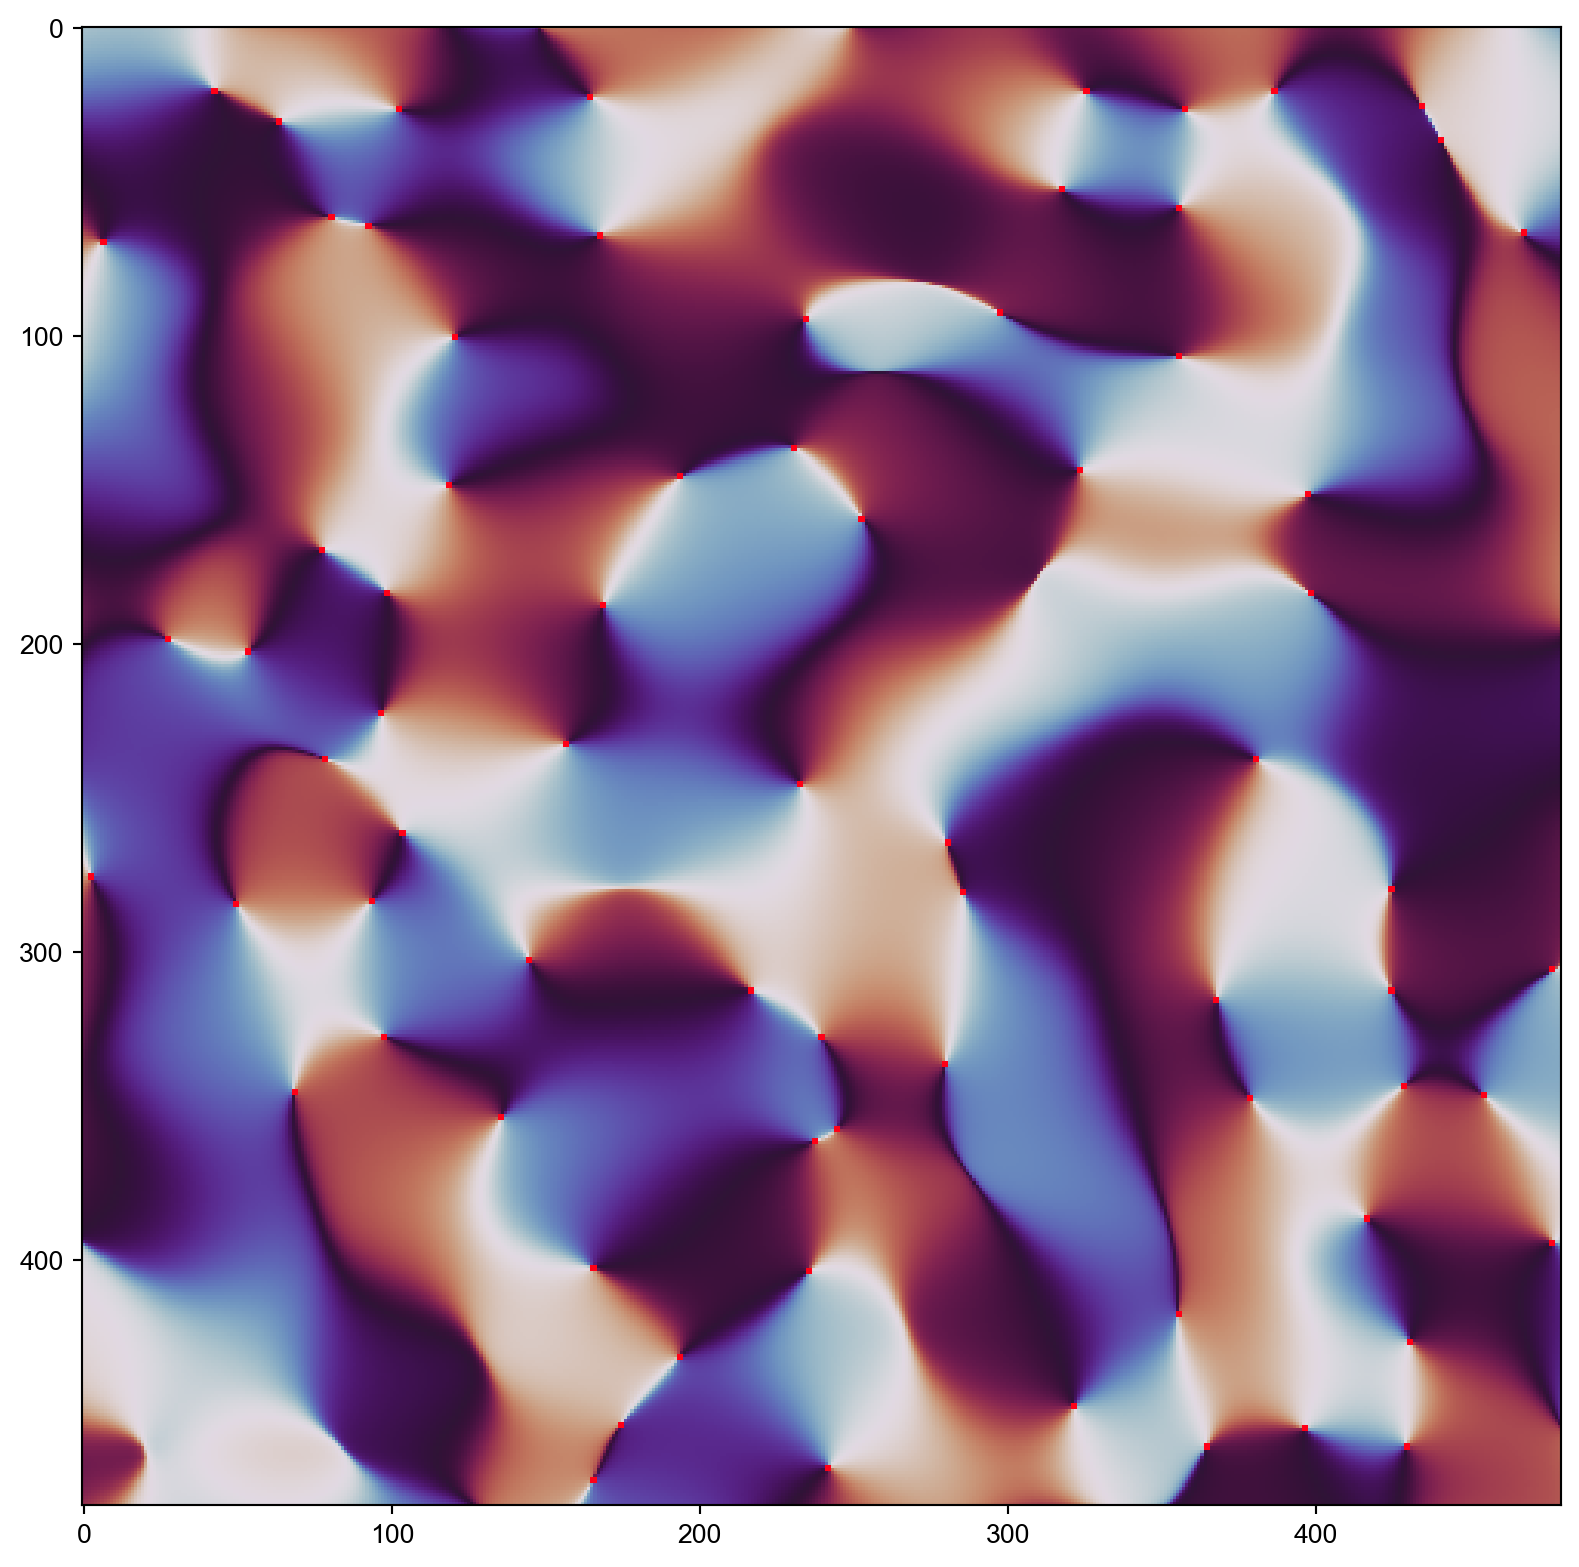

In [6]:
example_slice = rho_phase[:,:,1]
vortex_array = vortex_slice(example_slice)

#### plotting
fig = plt.figure(figsize=(10,10),dpi=192)
ax = fig.add_subplot(1, 1, 1)

ax.imshow(example_slice, vmin=-np.pi, vmax=np.pi, 
        cmap='twilight',interpolation='none')
# ax.imshow((example_slice-np.pi)**2, vmin=0.0, vmax=0.1**2, 
#         cmap='gray',interpolation='none', alpha=0.5)
ax.imshow(vortex_array, vmin=0, vmax=1, 
        cmap='hsv',interpolation='none', alpha=vortex_array)
# ax.grid(True, which='minor', axis='both', linestyle='-', color='k', lw=2)

# ax.set_xlim([0,250])
# ax.set_ylim([0,250])

In [7]:
def vortex_phase(rho_phase):
    """
    Scan over the simulation cell and identify defects.

    Input:
        rho_phase: The 3D density phase array.

    Output:
        vortex_volume: The 3D array identifying defect position.
    """

    ## scanning over the simulation cell
    n_slices = rho_phase.shape[1]
    vortex_volume = np.ones_like(rho_phase)
    for ax in range(3):
        axis_slice = ax
        vortex_array_list = []
        for i in trange(n_slices):
            rho_phase_slices = rho_phase.take(indices = i, axis=axis_slice)
            vortex_array = vortex_slice(rho_phase_slices)
            vortex_array_list.append(vortex_array)

        vortex_volume_ax = np.array(vortex_array_list)
        vortex_volume_ax = np.moveaxis(vortex_volume_ax,0,axis_slice)
        vortex_volume = vortex_volume*(1-vortex_volume_ax)

    vortex_volume = 1-vortex_volume

    return vortex_volume

### Call vortex_phase function

In [8]:
## call function
vortex_volume = vortex_phase(rho_phase)

100%|██████████| 480/480 [00:07<00:00, 63.25it/s]


##  Adjacency list

### Return lists of adjacent elements

In [9]:
def get_adjacency(array):
    """
    Input: 
        array: Binary array where 1 represent the voxels containing the vertex lines
    Output:
        positions_tuple_list: List of positions of the voxels (expressed in tuple)
        positions_list: List of positions of the voxels (expressed in raveled index)
        adjacent_list: List of inices of adjacent voxels (expressed in raveled index)
        adjacent_id_list: List of inices of adjacent voxels, 
                          which correspond to the index of positions_tuple_list and positions_list
    """
    # first part
    positions_tuple_list = []
    positions_list = []
    adjacent_list = []
    adjacent_id_list = []

    # Pad the array to simplify boundary checks
    padded_array = np.pad(array, pad_width=1, mode='constant', constant_values=0)

    # Define the kernel for directly connected neighboring elements
    kernel = np.zeros((3, 3, 3), dtype=int)
    ones_list = [[0,1,1],[2,1,1],[1,0,1],[1,2,1],[1,1,0],[1,1,2]]
    for index in ones_list:
        i,j,k = index
        kernel[i,j,k] = 1

    # # include "edge" elements
    # kernel = np.ones((3, 3, 3), dtype=int)
    # zeros_list = [[0,0,0],[2,0,0],[0,2,0],[0,0,2],[0,2,2],[2,0,2],[2,2,0],[2,2,2],[1,1,1]]
    # for index in zeros_list:
    #     i,j,k = index
    #     kernel[i,j,k] = 0
    # kernel[1, 1, 1] = 0  # Exclude the center element

    # Find positions labeled as 1
    labeled_positions = np.argwhere(array == 1)

    for index, pos in enumerate(labeled_positions):
        i, j, k = pos
        current_pos = tuple(pos)
        current_pos_ravel = np.ravel_multi_index(pos,array.shape)
        adjacent_positions = []

        # Get neighboring positions
        neighbors = padded_array[i:i+3, j:j+3, k:k+3] * kernel

        # Find adjacent positions labeled as 1
        adjacent_indices = np.argwhere(neighbors == 1)
        for index in adjacent_indices:
            x, y, z = index - 1  # Adjust indices to get relative positions
            # adjacent_positions.append((i + x, j + y, k + z))
            adjacent_positions.append(np.ravel_multi_index([i + x, j + y, k + z], array.shape))
        
        positions_tuple_list.append(current_pos)
        positions_list.append(current_pos_ravel)
        adjacent_list.append(adjacent_positions)

    # second part: map adjacent_list to indices of positions_list
    # accelerate position mapping by constructing dictionary
    ravel_index_map = {ravel_index: idx for idx, ravel_index in enumerate(positions_list)}

    for index in range(len(positions_tuple_list)):
        adjacent_id = [ravel_index_map[adjacent] for adjacent in adjacent_list[index]]
        adjacent_id_list.append(adjacent_id)

    return positions_tuple_list, positions_list, adjacent_list, adjacent_id_list

In [10]:
array = vortex_volume
positions_tuple_list, positions_list, adjacent_list, adjacent_id_list = get_adjacency(array)
poslist_arr = np.array(positions_tuple_list)

### Return connected components according to the adjacency list

In [11]:
def get_connected_part(adjacent_id_list):
    """
    Label connected parts (one-based) by performing a depth-first search (DFS) using a stack
    """
    # check list, output list, and counter
    checked = set()
    parts_arr = np.zeros(len(adjacent_id_list), dtype=int)
    max_part = 0

    for index, adjacent_id in enumerate(adjacent_id_list):
        if index not in checked:
            max_part += 1
            parts_arr[index] = max_part
            checked.add(index)

        stack = [index]
        while stack:
            current = stack.pop()
            for neighbor in adjacent_id_list[current]:
                if neighbor not in checked:
                    parts_arr[neighbor] = max_part
                    checked.add(neighbor)
                    stack.append(neighbor)

    return parts_arr

Text(0, 0.5, 'Size')

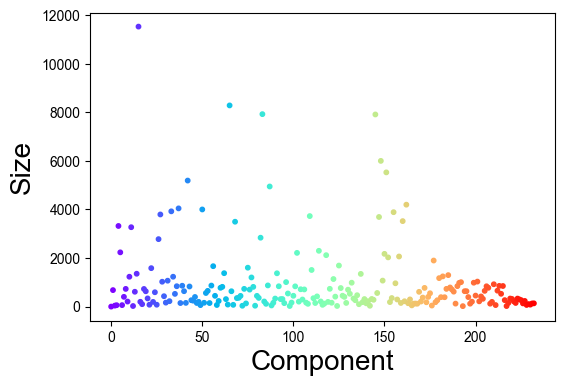

In [12]:
parts_arr = get_connected_part(adjacent_id_list)
max_part = np.max(parts_arr)

fig = plt.figure(figsize=(6,4))
ax = fig.add_subplot(1, 1, 1)

size_list = [np.sum(parts_arr==i) for i in range(max_part)]

ax.scatter(np.arange(max_part), size_list, s=10, c=np.arange(max_part),alpha=1,cmap='rainbow')

ax.set_xlabel('Component',fontsize=20)
ax.set_ylabel('Size',fontsize=20)

### Generate sample points representing the vortex cores

In [13]:
# positions_tuple_list, positions_list, adjacent_list, adjacent_id_list
def get_core(positions_tuple_list, adjacent_id_list, cluster_size = 5):
    poslist_arr = np.array(positions_tuple_list)
    parts_arr = get_connected_part(adjacent_id_list)

    sample = []
    sample_adj_list = []
    sample_adj_dict = []

    for i in range(max_part):
        current_id = np.where(parts_arr == i + 1)[0]
        current_adjacent_id = [adjacent_id_list[i] for i in current_id]

        poslist_arr_current = poslist_arr[current_id]  # points within the current part

        current_sample = []
        current_sample_parent = []

        checked = set()
        for j, adjacent_id in enumerate(current_adjacent_id):
            index = current_id[j]

            if index in checked:
                continue

            stack = [index]
            stack_sample_id = [1]  # index of current sample

            while stack:
                current = stack.pop()
                prev_sample_id = stack_sample_id.pop()

                if current in checked:
                    continue    
                
                # generate a list of neighbors of the current vertex
                d_sq = np.sum((poslist_arr_current - poslist_arr[current, :]) ** 2, axis=1)
                cluster_id = np.where(d_sq < (cluster_size ** 2))[0]

                # generate sample point
                cluster = poslist_arr_current[cluster_id]
                current_sample.append(np.mean(cluster, axis=0))

                # record the connections between sample points
                current_sample_parent.append(prev_sample_id)

                # not checking the particles in the current cluster
                adjacent_current = []  # adjacent of the current cluster
                for neighbor in current_id[cluster_id]:
                    checked.add(neighbor)  # consider the points in the current cluster as checked
                    adjacent_current.extend(adjacent_id_list[neighbor])
                adjacent_current = list(set(adjacent_current) - set(current_id[cluster_id]))

                # continue searching for the neighbors of the current cluster
                for neighbor in adjacent_current:
                    if neighbor not in checked:
                        stack.append(neighbor)
                        stack_sample_id.append(len(current_sample) - 1)  # Store the index of the current sample point

        # build adjacency dict
        if len(current_sample_parent)>1:
            adj_dict = {idx:set([connection]) for idx, connection in enumerate(current_sample_parent)}
            for idx, connection in enumerate(current_sample_parent):
                adj_dict[connection].add(idx) 
        else: 
            adj_dict = {}

        # build adjacency list
        adj_list = []
        if len(current_sample_parent)>1:
            adj_list = [list(adj_dict[idx]) for idx in range(len(current_sample))]

        sample.append(current_sample)
        sample_adj_list.append(adj_list)
        sample_adj_dict.append(adj_dict)
        
    return sample, sample_adj_list, sample_adj_dict

### Generate ordered list of sample points

In [14]:
# Obtain core sample points and adjacency lists
sample, sample_adj_list, sample_adj_dict = get_core(positions_tuple_list, adjacent_id_list)

def get_ordered_points(sample, sample_adj_list, sample_adj_dict):
    sample_ordered = []
    for i, (adj_list, adj_dict) in enumerate(zip(sample_adj_list, sample_adj_dict)):
        visited_nodes = set()
        sample_reorder = []

        # If the sample has more than one node
        if len(sample[i]) > 1:

            # Recursive function to traverse the adjacency list from a given node
            def traverse_adj_list(node, adj_list, visited, sample_reorder):
                visited.add(node)
                sample_reorder.append(sample[i][node])
                for neighbor in adj_list[node]:
                    if neighbor not in visited:
                        traverse_adj_list(neighbor, adj_list, visited, sample_reorder)

            # Calculate the connectivity of each node
            connectivity = np.array([len(adj) for adj in adj_list])

            # Identify nodes with connectivity greater than 2 (possible intersections)
            intersects = np.where(connectivity > 2)[0]

            # If there are intersect nodes, split the sample into branches
            if len(intersects) > 0:
                intersect = intersects[0]  # Consider the first intersect node
                visited_nodes.add(intersect)
                # Traverse the adjacency list from the intersect node for each branch
                for neighbor in adj_list[intersect]:
                    if neighbor not in visited_nodes:
                        sample_reorder = [] # New empty list for each branch
                        visited_nodes.add(neighbor) # Traverse the branch from this neighbor
                        traverse_adj_list(neighbor, adj_list, visited_nodes, sample_reorder)

                        if len(sample_reorder) > 1:
                            sample_ordered.append(sample_reorder)
            else:
                # If there are no intersect nodes, find the ends of the branches
                ends = np.where(connectivity != 2)[0]
                if len(ends) == 0:
                    end = 0
                else:
                    end = ends[0]
                traverse_adj_list(end, sample_adj_list[i], visited_nodes, sample_reorder)

        else:
            # If there's only one node, append it directly
            sample_reorder.append(sample[i][0])

        sample_ordered.append(sample_reorder)

    return sample_ordered


Text(0, 0.5, 'Size of sample points')

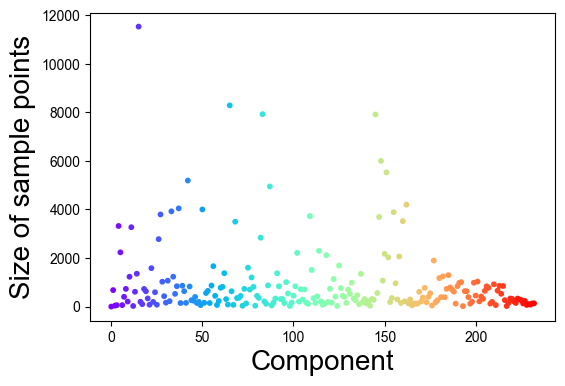

In [15]:
parts_arr = get_connected_part(adjacent_id_list)
max_part = np.max(parts_arr)

sample, sample_adj_list, sample_adj_dict = get_core(positions_tuple_list, adjacent_id_list)

fig = plt.figure(figsize=(6,4))
ax = fig.add_subplot(1, 1, 1)

ax.scatter(np.arange(max_part), size_list, s=10, c=np.arange(max_part),alpha=1,cmap='rainbow')

ax.set_xlabel('Component',fontsize=20)
ax.set_ylabel('Size of sample points',fontsize=20)

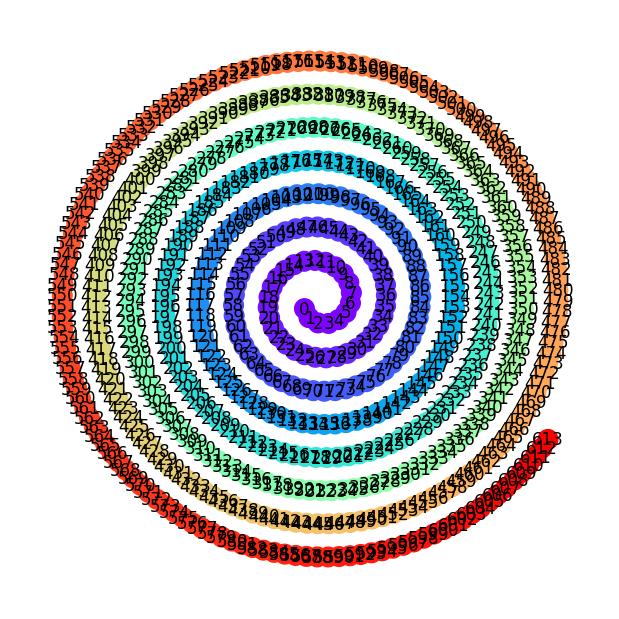

In [16]:
import networkx as nx
# Create an empty graph
G = nx.Graph()

defect_id = np.argmax(size_list)-1
defect_adjacency = sample_adj_dict[defect_id]

# Add edges based on the connections in sample_adjacency    
for node, connections in defect_adjacency.items():
    for connection in connections:
        G.add_edge(node, connection)

pos = nx.spiral_layout(G,equidistant=True,resolution=1)
# Visualize the graph
plt.figure(figsize=(6, 6))
nx.draw(G, pos=pos, 
        with_labels=True, 
        node_color=range(node+1),cmap=plt.cm.rainbow,
        width=2, node_size=200)

# plt.title('Connection Topology of Sample Points')
plt.show()

(0.0, 480.0)

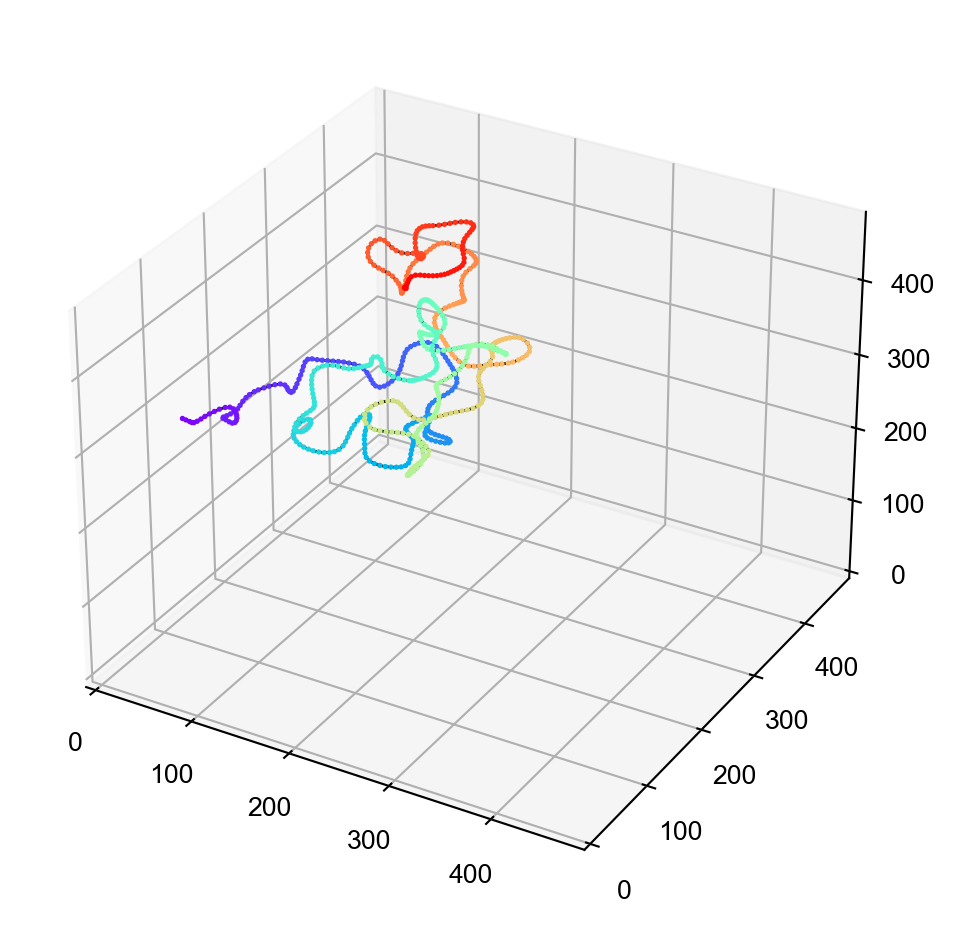

In [17]:
%matplotlib inline
fig = plt.figure(figsize=(6,6),dpi=192)
ax = fig.add_subplot(1, 1, 1, projection='3d')

# for i, sp in enumerate(sample):
for i, sp in enumerate([sample[defect_id]]):
    array_sample = np.array(sp)
    ax.scatter(array_sample[:,0],array_sample[:,1],array_sample[:,2],
        '.',c=np.arange(len(array_sample)),s=1,alpha=1,cmap='rainbow')
    ax.plot(array_sample[:,0],array_sample[:,1],array_sample[:,2],
        '-k',lw=1)

ax.set_xlim([0,480])
ax.set_ylim([0,480])
ax.set_zlim([0,480])

(0.0, 480.0)

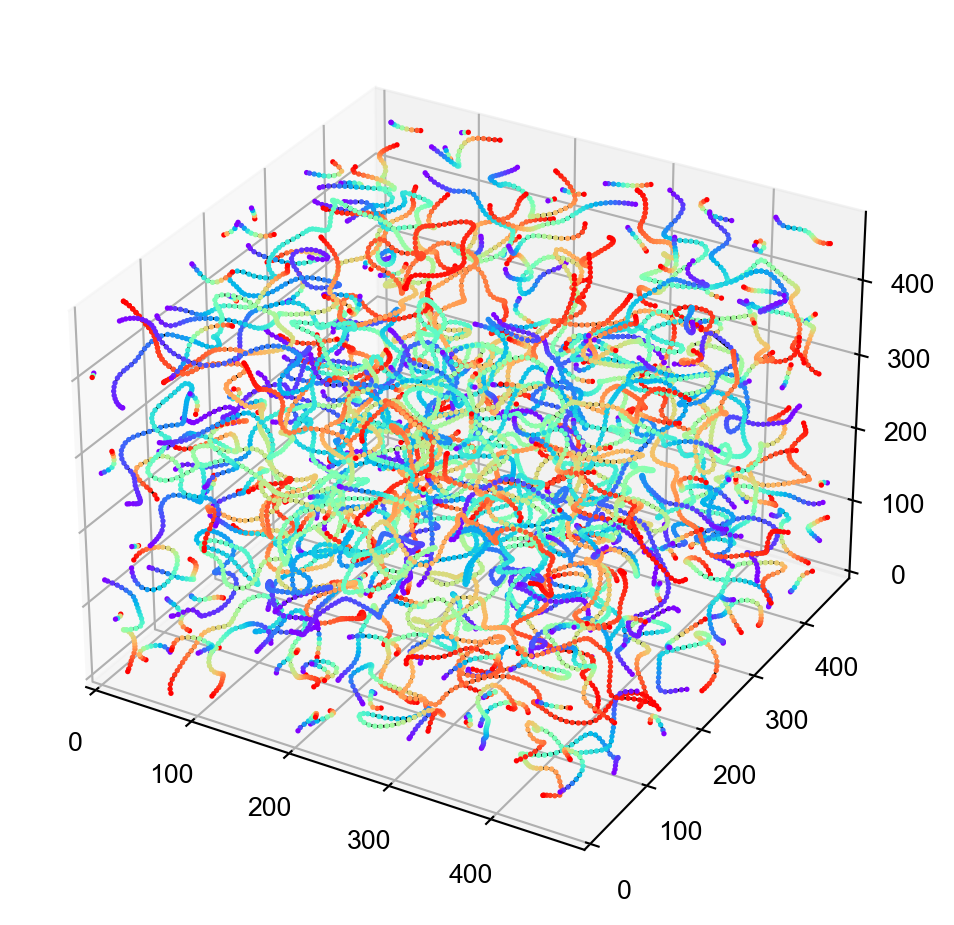

In [18]:
%matplotlib inline
fig = plt.figure(figsize=(6,6),dpi=192)
ax = fig.add_subplot(1, 1, 1, projection='3d')

sample_ordered = get_ordered_points(sample, sample_adj_list, sample_adj_dict)
# for i, sp in enumerate(sample):
for i, sp in enumerate(sample_ordered):
    if len(sp)<3:
        continue
    array_sample = np.array(sp)
    ax.scatter(array_sample[:,0],array_sample[:,1],array_sample[:,2],
        '.',c=np.arange(len(array_sample)),s=1,alpha=1,cmap='rainbow')
    ax.plot(array_sample[:,0],array_sample[:,1],array_sample[:,2],
        '-k',lw=1)

ax.set_xlim([0,480])
ax.set_ylim([0,480])
ax.set_zlim([0,480])

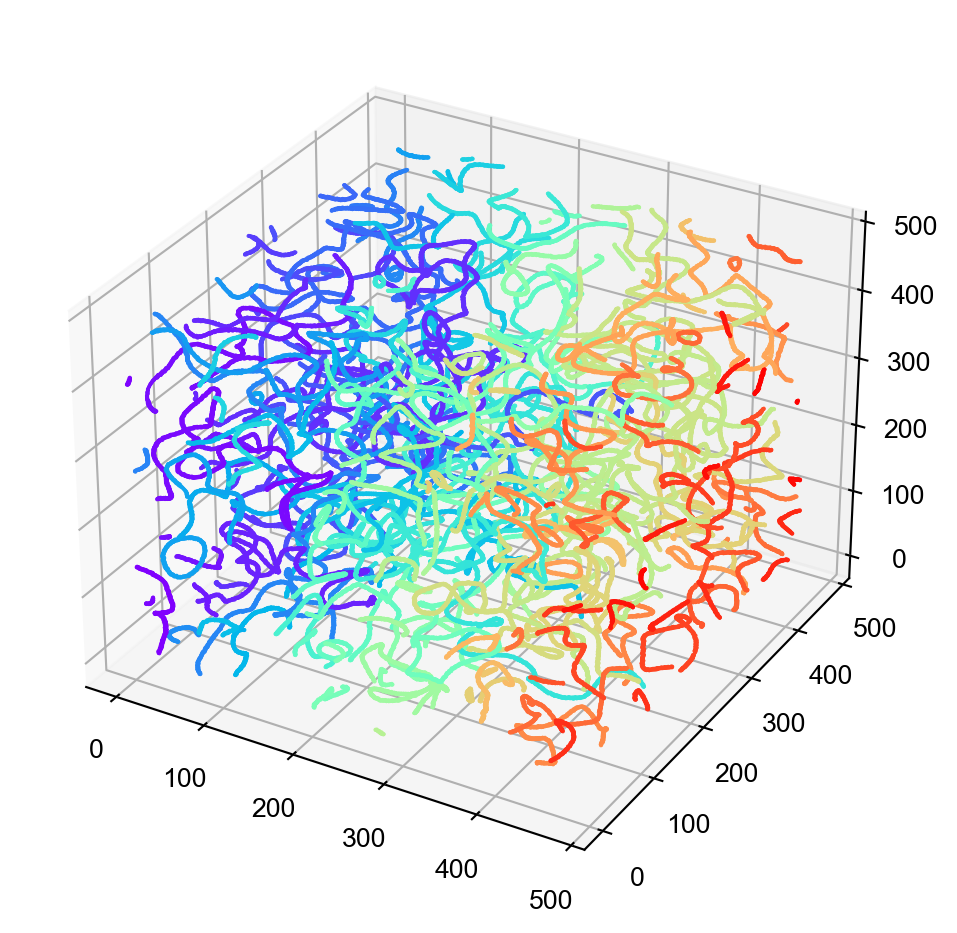

In [19]:
poslist_arr = np.array(positions_tuple_list)

# %matplotlib widget
fig = plt.figure(figsize=(6,6),dpi=192)
ax = fig.add_subplot(1, 1, 1, projection='3d')

# plot defect voxels
# ax.plot(poslist_arr[:,0],poslist_arr[:,1],poslist_arr[:,2],'.k')
ax.scatter(poslist_arr[:,0],poslist_arr[:,1],poslist_arr[:,2],
    '.',c=parts_arr,s=.1,alpha=1,cmap='rainbow')

(60.0, 70.0)

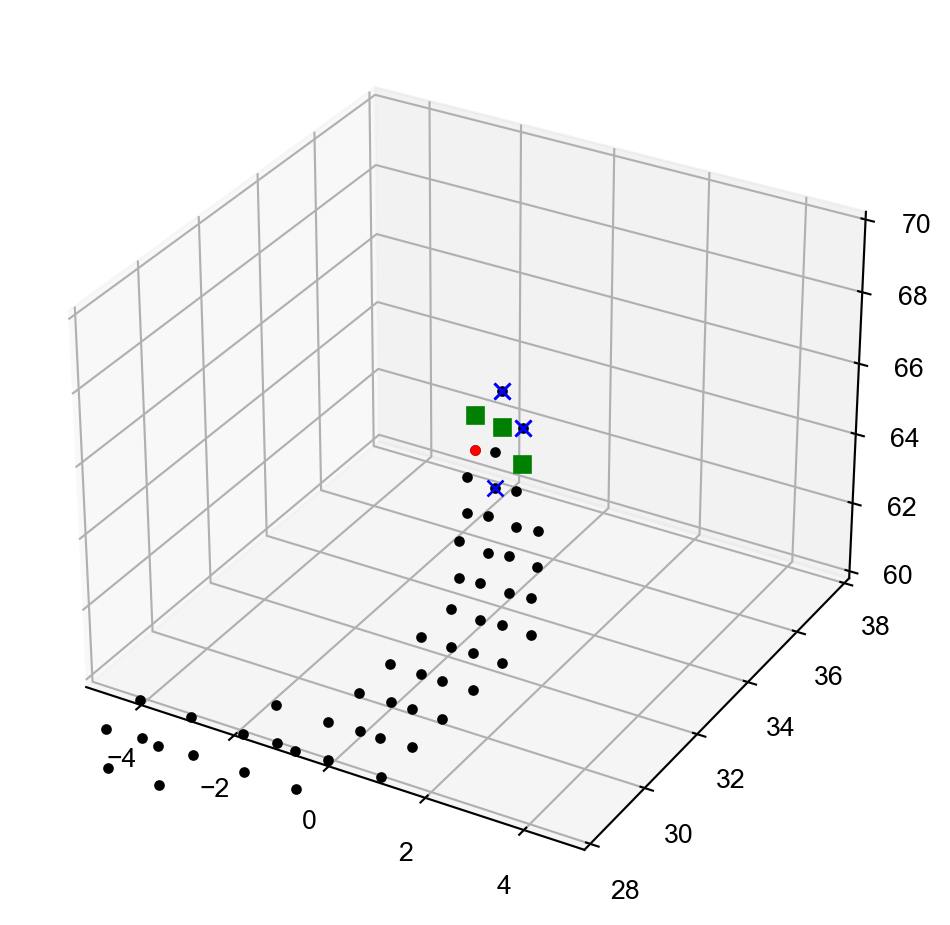

In [20]:
poslist_arr = np.array(positions_tuple_list)

# %matplotlib widget
fig = plt.figure(figsize=(6,6),dpi=192)
ax = fig.add_subplot(1, 1, 1, projection='3d')

# plot defect voxels
ax.plot(poslist_arr[:,0],poslist_arr[:,1],poslist_arr[:,2],'.k')
# ax.scatter(poslist_arr[:,0],poslist_arr[:,1],poslist_arr[:,2],
#     '.',c=parts_arr,s=.1,alpha=1,cmap='rainbow')

# given a sample, plot the sample and its neighbors
index_sample = 12
sample_pos = np.unravel_index(positions_list[index_sample],vortex_volume.shape)
ax.plot(poslist_arr[index_sample,0],poslist_arr[index_sample,1],poslist_arr[index_sample,2],'r.')
# for adjacent_positions in adjacent_list[index_sample]:
#     neighbor_pos = np.unravel_index(adjacent_positions,vortex_volume.shape)
#     ax.plot(neighbor_pos[0],neighbor_pos[1],neighbor_pos[2],'g.')
# positions_list_array[index_sample]

for adjacent_id in adjacent_id_list[index_sample]:
    ax.plot(poslist_arr[adjacent_id,0],poslist_arr[adjacent_id,1],poslist_arr[adjacent_id,2],'sg')
    
    # adjacent of adjacent 
    for adjacent_id2 in adjacent_id_list[adjacent_id]:
        if adjacent_id2==index_sample:
            continue
        ax.plot(poslist_arr[adjacent_id2,0],poslist_arr[adjacent_id2,1],poslist_arr[adjacent_id2,2],'xb')
 
poslist_arr[index_sample]

ax.set_xlim([sample_pos[0]-5,sample_pos[0]+5])
ax.set_ylim([sample_pos[1]-5,sample_pos[1]+5])
ax.set_zlim([sample_pos[2]-5,sample_pos[2]+5])

## Defect density

In [21]:
def defect_density(vortex_volume, r_grid):
    d_voxel = r_grid[0][0,1,0]-r_grid[0][0,0,0]
    d_cell = [(r_grid[0][0,-1,0]-r_grid[0][0,0,0]),
              (r_grid[1][-1,0,0]-r_grid[1][0,0,0]),
              (r_grid[2][0,0,-1]-r_grid[2][0,0,0])] 
    sum_voxel = np.sum(vortex_volume) # total volume of defective voxels (pixel^3)
    cross_voxel = 4 # crossection of defective voxels (pixel^2)
    length = sum_voxel/cross_voxel # length of defect line (pixel)

    cell_volume = d_cell[0]*d_cell[1]*d_cell[2]
    line_density = length*d_voxel/cell_volume

    return(line_density)


In [22]:
defect_density(vortex_volume,r_grid)

28.55193110647159

## Visualization

In [23]:
def visualize_lamellar(rho_real,vortex_volume,
                       lamellar=True,isometric=False,
                       filename = './test_lamellar_vortex.png'):
    # pyvista
    # https://stackoverflow.com/questions/6030098
    grid = pv.StructuredGrid(r_grid[0], r_grid[1], r_grid[2])
    grid["vol"] = rho_real.flatten('F')
    mesh = grid.contour([alpha])

    grid["vol"] = vortex_volume.flatten('F')
    mesh2 = grid.contour([0.5])

    # Visualization
    pv.set_plot_theme('document')
    pl = pv.Plotter(window_size=[600, 600])
    pl.enable_anti_aliasing('msaa')

    if lamellar:
        backface_params = dict(color='#303030',
                            ambient=0.2, diffuse=0.8, specular=0.1, specular_power=10,
                            opacity=1
                            )
        pl.add_mesh(mesh, show_scalar_bar=False, color='#A0A0A0',  
                    ambient=0.2, diffuse=0.8, specular=0.1, specular_power=10,
                    backface_params=backface_params, 
                    smooth_shading=True, 
                    opacity=1
                    )

    pl.add_mesh(mesh, opacity=0, show_scalar_bar=False)

    backface_params_defect = dict(color='#FF0000',
                        ambient=0.2, diffuse=0.8, specular=0.1, specular_power=10,
                        opacity=0.5
                        )
    pl.add_mesh(mesh2, show_scalar_bar=False, color='#FF0000',  
                ambient=0.2, diffuse=0.8, specular=0.1, specular_power=10,
                backface_params=backface_params_defect, 
                smooth_shading=True, 
                opacity=0.5
                )

    if isometric:
        # camera setting
        pl.enable_parallel_projection()
        pl.camera_position = 'yz'
        pl.camera.reset_clipping_range()
    else:
        # camera setting
        pl.camera_position = 'yz'
        pl.camera.azimuth = -60.0
        pl.camera.elevation = 24.0
        pl.camera.reset_clipping_range()

    # light setting
    light = pv.Light()
    light.set_direction_angle(21, -55.0)
    light.attenuation_values = (0,0,2)
    pl.add_light(light)

    pl.add_bounding_box()
    pl.show(screenshot=filename)
    # pl.close(render=False)

In [24]:
# visualize_lamellar(rho_real, vortex_volume)

In [25]:
visualize_lamellar(rho_real, vortex_volume, lamellar=False, filename='./test_vortex.png')

Widget(value="<iframe src='http://localhost:59738/index.html?ui=P_0x15d39ee1160_0&reconnect=auto' style='width…

## Animation

In [26]:
# for i in trange(rho_phase.shape[2]):
#     example_slice = rho_phase[:,:,i]
#     vortex_array = vortex_slice(example_slice)

#     #### plotting
#     fig = plt.figure(figsize=(5,5),dpi=96)
#     ax = fig.add_subplot(1, 1, 1)

#     ax.imshow(example_slice, vmin=-np.pi, vmax=np.pi, 
#             cmap='twilight',interpolation='none')
#     # ax.imshow((example_slice-np.pi)**2, vmin=0.0, vmax=0.1**2, 
#     #         cmap='gray',interpolation='none', alpha=0.5)
#     ax.imshow(vortex_array, vmin=0, vmax=1, 
#             cmap='gray',interpolation='none', alpha=(vortex_array+1)/2)
#     # ax.grid(True, which='minor', axis='both', linestyle='-', color='k', lw=2)

#     # ax.set_xlim([0,250])
#     # ax.set_ylim([0,250])
#     ax.set_xticks([])
#     ax.set_yticks([])

#     plt.tight_layout()
#     filename = "./Figures/gif/slice_phase_{:04d}".format(i)
#     plt.savefig(filename)
#     plt.close()

In [27]:
# import PIL
# import glob
# import imageio

# anim_file = './Figures/gif/scan.gif'
# with imageio.get_writer(anim_file, mode='I', duration=1000/30) as writer:
#     filenames = glob.glob('./Figures/gif/slice_phase_*.png')
#     filenames = sorted(filenames)
#     for filename in filenames:
#         image = imageio.imread(filename)
#         writer.append_data(image)
#     image = imageio.imread(filename)
#     writer.append_data(image)


## Layer thickness

In [28]:
def layer_thickness(rho_real,alpha=0):
    ## estimate layer thickness
    rho_bi = np.zeros_like(rho_real)
    rho_bi[rho_real>alpha] = 1
    slice_0 = rho_bi[:,:,0] # type of elements in the first slice

    array_interface = np.zeros_like(rho_real)
    for i in trange(rho_bi.shape[2]-1):
        array_interface[:,:,i+1] = rho_bi[:,:,i+1] - rho_bi[:,:,i]

    list_thickness_w = []
    list_thickness_b = []
    for j in trange(rho_bi.shape[0]):
        for k in range(rho_bi.shape[0]):
            first_element = int(slice_0[j,k])
            array_interface_jk = array_interface[j,k,:].nonzero()[0]
            distances = array_interface_jk[1:]-array_interface_jk[:-1]
            distances_w = [distances[i] for i in range(len(distances)) if i%2==first_element]
            distances_b = [distances[i] for i in range(len(distances)) if i%2!=first_element]
            list_thickness_w += distances_w
            list_thickness_b += distances_b

    return(np.array(list_thickness_w),np.array(list_thickness_b))

100%|██████████| 480/480 [00:01<00:00, 430.35it/s]


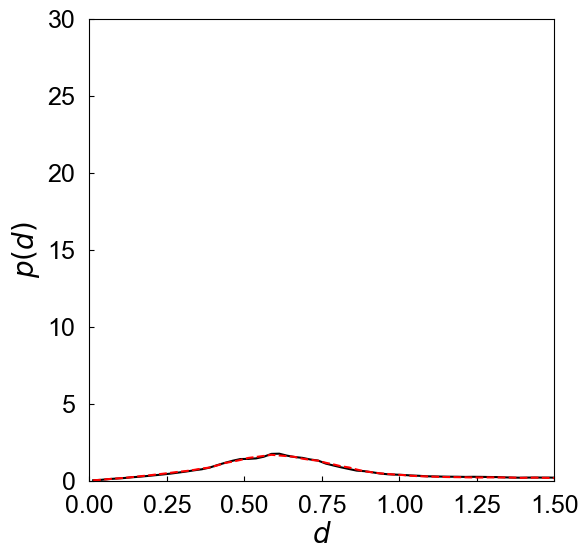

In [29]:
array_thickness_w,array_thickness_b = layer_thickness(rho_real,alpha=alpha)

thickness_scale = 2/rho_real.shape[2]*scale
bins = np.arange(100)/40
histogram_w = np.histogram(array_thickness_w*thickness_scale,bins,density=True)
histogram_b = np.histogram(array_thickness_b*thickness_scale,bins,density=True)

#### plotting
fig = plt.figure(figsize=(6,6))
ax = fig.add_subplot(1, 1, 1)

ax.plot(histogram_b[1][:-1]+(bins[1]-bins[0])/2,histogram_b[0],'-k')
ax.plot(histogram_w[1][:-1]+(bins[1]-bins[0])/2,histogram_w[0],'--r')
ax.set_xlim([0,1.5])
ax.set_ylim([0,30])

ax.set_xlabel(r'$d$',fontsize=20)
ax.set_ylabel(r'$p(d)$',fontsize=20)
# ax.set_xscale('log')
ax.tick_params(direction='in', axis='both', which='both', labelsize=18, pad=10)